<a href="https://colab.research.google.com/github/LuccaPaiva/portfolio/blob/main/letterboxd/letterboxd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

#import letterboxd
#utils
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from ast import literal_eval

#html
import requests
from bs4 import BeautifulSoup
import json

#gsheets
from google.colab import auth
from gspread_dataframe import set_with_dataframe
import gspread
import gspread_dataframe as gdf
from google.auth import default

#map
from matplotlib.patches import Polygon
!pip install basemap
from mpl_toolkits.basemap import Basemap
import geopandas as gpd
from shapely.geometry import Point
import matplotlib
import matplotlib.colors as mcolors
import matplotlib.cm as cm

## Auth

In [ ]:
#nome_de_usuario = "BeyBlade"
auth.authenticate_user()
creds, _ = default()

Setting Spreadsheet

In [ ]:
gc = gspread.authorize(creds)
lbxd_spreadsheet = gc.open("letterboxd")

## Data

### Import

In [ ]:
def get_diary():
  diary_worksheet = lbxd_spreadsheet.worksheet("diary")
  diary = pd.DataFrame(diary_worksheet.get_all_records())
  diary.rename(columns={'Letterboxd URI': 'Review URI'}, inplace=True)
  #diary.rename(columns={'Date': 'Log Date'}, inplace=True)

  return diary

In [ ]:
def get_watched():
  watched_worksheet = lbxd_spreadsheet.worksheet("watched")
  watched = pd.DataFrame(watched_worksheet.get_all_records())
  #watched.rename(columns={'Date': 'Date'}, inplace=True)
  return watched

## Data Manipulation

In [ ]:
genre_retirieved = False
try:
  data_worksheet = lbxd_spreadsheet.worksheet("data")
  merged_df = pd.DataFrame(data_worksheet.get_all_records())
  country_retrieved = True
except:
  diary = get_diary()
  watched = get_watched()
  merged_df = pd.merge(diary, watched, on=['Name', "Year"])
  country_retrieved = False
  genre_retirieved = False
merged_df, country_retrieved

(         Date_x                             Name  Year  \
 0    2020-08-31                     Palm Springs  2020   
 1    2020-08-31                         Sertânia  2019   
 2    2020-08-31                          Arrival  2016   
 3    2020-08-31                      Da 5 Bloods  2020   
 4    2020-08-31                       Game Night  2018   
 ..          ...                              ...   ...   
 387  2024-05-21                      Challengers  2024   
 388  2024-05-21  It's a Mad, Mad, Mad, Mad World  1963   
 389  2024-05-30                     The Hot Rock  1972   
 390  2024-06-01                       La Chimera  2023   
 391  2024-06-05                        Barbarian  2022   
 
                  Review URI Rating Rewatch                   Tags  \
 0    https://boxd.it/1kuvvH     35     Yes              fun, leve   
 1    https://boxd.it/1ktSDd      4                       denso, ?   
 2    https://boxd.it/1ktS1X      5                                  
 3    http

In [ ]:
def get_movie_country(movie_url = "https://boxd.it/vzVi"):
  response = requests.get(movie_url)
  html_content = response.content
  soup = BeautifulSoup(html_content, "html.parser")
  target_element = soup.find(id="tabbed-content")
  target_elements = target_element.select("a[href*='/films/country/']")
  country = []
  for element in target_elements:
    country.append(element.text)
  return country

print(get_movie_country())

['France', 'Italy', 'Switzerland', 'Turkey']


In [ ]:
def get_movie_genres(movie_url = "https://boxd.it/vzVi"):
  response = requests.get(movie_url)
  html_content = response.content
  soup = BeautifulSoup(html_content, "html.parser")
  target_element = soup.find(id="tabbed-content")
  target_elements = target_element.select("a[href*='/films/genre/']")
  genres = []
  for element in target_elements:
    genres.append(element.text)
  return genres

print(get_movie_genres())

['Comedy', 'Adventure', 'Drama', 'Fantasy']


In [ ]:
if not country_retrieved:
  movie_countries = []

  # Loop through each movie URL in the dataframe
  for movie_url in merged_df['Letterboxd URI']:
    # Get the countries for the current movie
    countries = get_movie_country(movie_url)
    # Append the countries to the list
    movie_countries.append(countries)

  # Add a new column named "Country" to the dataframe
  merged_df['Country'] = movie_countries

  data_worksheet = lbxd_spreadsheet.worksheet("data")
  set_with_dataframe(worksheet=data_worksheet, dataframe=merged_df, include_index=False, include_column_header=True, resize=True)

  merged_df

if not genre_retirieved:
  movie_genres = []

  # Loop through each movie URL in the dataframe
  for movie_url in merged_df['Letterboxd URI']:
    # Get the countries for the current movie
    genres = get_movie_genres(movie_url)
    # Append the countries to the list
    movie_genres.append(genres)

  # Add a new column named "Country" to the dataframe
  merged_df['Genres'] = movie_genres

if not country_retrieved or not genre_retirieved:
  data_worksheet = lbxd_spreadsheet.worksheet("data")
  set_with_dataframe(worksheet=data_worksheet, dataframe=merged_df, include_index=False, include_column_header=True, resize=True)

  merged_df

## Data Visualization

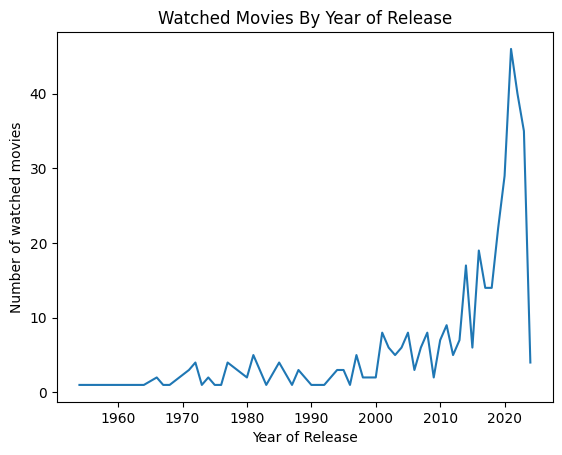

In [ ]:
movie_by_year = merged_df['Year'].value_counts().sort_index()

fig = plt.figure()
plt.plot(movie_by_year)
plt.title("Watched Movies By Year of Release")
plt.xlabel("Year of Release")
plt.ylabel("Number of watched movies")
plt.show()

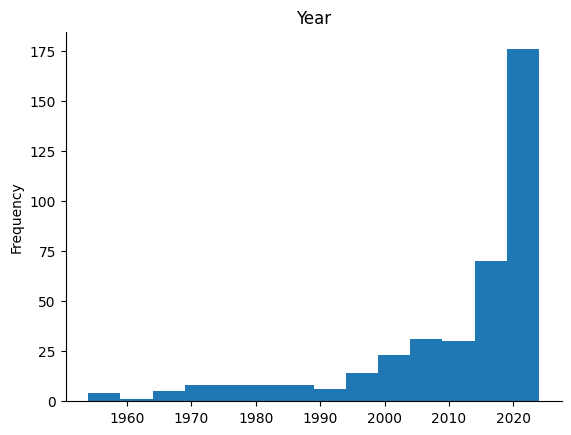

In [ ]:
merged_df['Year'].plot(kind='hist', title='Year', bins=range(min(merged_df['Year']), max(merged_df['Year'])+1, 5))
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
def movie_count(tag):
  movie_count = {}
  for collection in merged_df[tag]:
    print(collection)
    c = literal_eval(collection)
    for item in c:
        if item in movie_count:
          movie_count[item] += 1
        else:
          movie_count[item] = 1
  return movie_count

movie_count_by_country = movie_count('Country')
movie_count_by_genre = movie_count('Genres')
movie_count_by_country, movie_count_by_genre


['USA']
['Brazil']
['USA']
['USA']
['USA']
['Japan', 'UK', 'USA']
['USA']
['China', 'Hong Kong']
['Indonesia', 'USA']
['Indonesia', 'USA']
['USA']
['Canada', 'USA']
['USA']
['USA']
['USA']
['USA']
['USA']
['USA']
['Poland']
['USA']
['Japan']
['South Korea']
['USA']
['Japan']
['Thailand']
['Hong Kong']
['Hong Kong']
['Japan']
['USA']
['USA']
['Hong Kong', 'Netherlands', 'Singapore']
['New Zealand', 'USA']
['Japan']
['UK', 'USA']
['Australia', 'USA']
['Australia', 'USA']
['France', 'UK', 'USA']
['China', 'USA', 'Hong Kong']
['USA']
['Malaysia', 'Portugal', 'USA']
['USA']
['USA']
['France', 'Greece', 'Ireland', 'Netherlands', 'UK']
['USA', 'Japan', 'Singapore', 'South Korea']
['USA']
['USA']
['USA']
['USA']
['China']
['USA']
['USA']
['USA']
['China']
['USA', 'Canada']
['Japan']
['USA']
['USA']
['Japan']
['Brazil', 'France']
['USA']
['UK', 'USA']
['Brazil', 'France']
['USA']
['UK', 'USA']
['USA']
['USA']
['USA']
['Japan']
['USA']
['Hong Kong']
['USA']
['Hong Kong']
['USA']
['USA']
['Hong K

ValueError: malformed node or string: ['Romance', 'Science Fiction', 'Comedy']

In [ ]:
countries = list(movie_count_by_country.keys())

# Convert the dictionary to a DataFrame
df_movie_count = pd.DataFrame({
    'name': countries,
    'movie_count': list(movie_count_by_country.values())
})
df_movie_count = df_movie_count.sort_values(by='movie_count', ascending=False)

df_movie_count.loc[df_movie_count["name"] == "USA", "name"] = "United States of America"

df_movie_count.loc[df_movie_count["name"] == "UK", "name"] = "United Kingdom"

df_movie_count.head()

In [ ]:
# Plot the bar chart
no_USA = df_movie_count.iloc[1:]
no_USA = no_USA[no_USA["movie_count"] > 1]
no_USA.plot(kind='bar', x='name', y='movie_count', color='skyblue')

# Add a title and axis labels
plt.title('Number of Movies Watched by Country')
plt.xlabel('Country')
plt.ylabel('Number of Movies')
plt.tight_layout()
for y in range(10, 50, 10):
    plt.axhline(y, color='gray', linestyle='--', alpha=0.5)

plt.legend(title="Movies per Country")

# Rotate the x-axis labels for better readability
plt.xticks(rotation=90)

# Show the plot
plt.show()
no_USA.head()

### Mapa

In [ ]:
#Read the world data and show the header
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.head(), world.shape

In [ ]:
#Use pyplot (plt) to plot a country map such as New Zealand
fig, ax_nz = plt.subplots(figsize=(8,6))
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries[countries["name"] == "New Zealand"].plot(cmap='Blues_r', ax=ax_nz)
plt.show()

In [ ]:
test = pd.merge(world, df_movie_count, on=['name'], how='left')
test['movie_count'] = test['movie_count'].fillna(0)
test.loc[test["name"] == "United States of America", "movie_count"] = 49
test = test[test["movie_count"] > 0]
test = test.sort_values(by='movie_count', ascending=False)
test[["name", "movie_count"]]

In [ ]:
ig, ax = plt.subplots(figsize=(12,6))
my_cmap = []
test.plot(column='movie_count', cmap="Oranges", ax=ax, legend=True, legend_kwds={'label': "Movies per Country", 'orientation': "horizontal"})
